In [119]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [120]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from japanmap import picture
import numpy as np
import os
import pandas as pd
from PIL import Image
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int

In [121]:
populations = {}
all_population = 0
with codecs.open("population.txt", encoding='utf-8') as f:
    l = f.readline()
    while l:
        elems = l.split(',')
        populations[elems[3]] = dict(
            region = int(elems[0]),
            code   = int(elems[1]),
            ja     = elems[2],
            en     = elems[3],
            total = int(elems[4])
        )
        all_population += int(elems[4])
        l = f.readline().replace("\r\n", "").rstrip()
print("All population in Japan: {}".format(all_population))

All population in Japan: 127094745


In [122]:
#print(populations)

In [123]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [124]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [137]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # 実効再生産数
poss = [] # 陽性者数
test = [] # 検査数
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    test.append(np.zeros(n_states+1).tolist())
    test[i][0] = poss[i][0] = erns[i][0] = i

In [147]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        if tested > 0:
            test[dt_idx][st_idx] = blank2zero(elems[offsets['tests']])
        cnt += 1
print("Load {} lines.".format(cnt))

Load 9913 lines.


In [148]:
erns = np.array(erns)
poss = np.array(poss)
test = np.array(test)

In [149]:
def get_os_idx_of_arr(arr, delta_days):
    os_idx = -1
    for i in np.arange(delta_days):
        if np.sum(arr[-i -1, 1:])  > 0:
            os_idx = -i -1
            print("Data offset index: {}".format(os_idx))
            break
    return os_idx

def dump_val_in_arr(arr, prefix, dec_num=1):
    print("{}: ".format(prefix), end="")
    for k, v in populations.items():
        strfmt = "{}={:." + str(dec_num) + "f} "
        print(strfmt.format(v['ja'], np.round(arr[v['code']], dec_num)), end="")
    print("")

In [150]:
os_idx = get_os_idx_of_arr(erns, dt_delta)
latest_erns = erns[os_idx] # 最新の実効再生産数
dump_val_in_arr(latest_erns, "最新の実効再生産数")

Data offset index: -1
最新の実効再生産数: 北海道=1.2 青森=1.0 岩手=0.0 宮城=1.3 秋田=0.0 山形=0.0 福島=0.8 茨城=1.2 栃木=0.5 群馬=1.0 埼玉=1.3 千葉=1.3 東京=1.1 神奈川=1.1 新潟=0.0 山梨=3.6 長野=2.7 岐阜=0.5 静岡=1.5 愛知=0.8 三重=1.5 富山=3.2 石川=0.2 福井=0.0 滋賀=0.8 京都=0.8 大阪=1.0 兵庫=1.2 奈良=1.1 和歌山=0.6 鳥取=0.0 島根=0.0 岡山=1.1 広島=1.2 山口=1.0 徳島=0.0 香川=0.0 愛媛=0.0 高知=0.0 福岡=1.2 佐賀=1.0 長崎=0.0 熊本=17.3 大分=0.0 宮崎=0.0 鹿児島=0.8 沖縄=1.6 


In [151]:
def calc_last1w2w_dif(arr, name):
    idx = get_os_idx_of_arr(arr, dt_delta)
    latest_arr = arr[idx] # 最新
    last1w_arr = arr[idx -  7] # 1週間前
    last2w_arr = arr[idx - 14] # 2週間前
    diff1w_arr = latest_arr - last1w_arr # 最新と1週間前の差分
    diff2w_arr = latest_arr - last2w_arr # 最新と2週間前の差分
    dump_val_in_arr(diff1w_arr, "1週間{}".format(name), 0)
    dump_val_in_arr(diff2w_arr, "2週間{}".format(name), 0)
    return diff1w_arr, diff2w_arr

In [152]:
diff1w_poss, diff2w_poss = calc_last1w2w_dif(poss, "陽性者数")

Data offset index: -1
1週間陽性者数: 北海道=123 青森=1 岩手=1 宮城=36 秋田=5 山形=0 福島=18 茨城=28 栃木=11 群馬=29 埼玉=220 千葉=247 東京=1218 神奈川=387 新潟=0 山梨=12 長野=8 岐阜=8 静岡=26 愛知=147 三重=35 富山=10 石川=2 福井=0 滋賀=11 京都=56 大阪=357 兵庫=123 奈良=14 和歌山=2 鳥取=0 島根=0 岡山=7 広島=71 山口=3 徳島=2 香川=0 愛媛=1 高知=0 福岡=30 佐賀=1 長崎=2 熊本=54 大分=0 宮崎=0 鹿児島=24 沖縄=166 
2週間陽性者数: 北海道=221 青森=2 岩手=1 宮城=61 秋田=5 山形=0 福島=44 茨城=50 栃木=38 群馬=58 埼玉=372 千葉=418 東京=2244 神奈川=745 新潟=5 山梨=14 長野=10 岐阜=31 静岡=41 愛知=334 三重=55 富山=12 石川=22 福井=0 滋賀=27 京都=128 大阪=741 兵庫=222 奈良=26 和歌山=6 鳥取=0 島根=3 岡山=13 広島=128 山口=6 徳島=2 香川=0 愛媛=1 高知=1 福岡=53 佐賀=2 長崎=2 熊本=55 大分=0 宮崎=0 鹿児島=58 沖縄=249 


In [153]:
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage

In [158]:
diff1w_test, diff2w_test = calc_last1w2w_dif(test, "検査数")

Data offset index: -1
1週間検査数: 北海道=3613 青森=126 岩手=225 宮城=717 秋田=42 山形=76 福島=1425 茨城=264 栃木=2326 群馬=2759 埼玉=6548 千葉=10894 東京=24367 神奈川=10413 新潟=572 山梨=252 長野=760 岐阜=1080 静岡=1796 愛知=4940 三重=1105 富山=1048 石川=964 福井=188 滋賀=542 京都=2481 大阪=10914 兵庫=3082 奈良=991 和歌山=133 鳥取=72 島根=177 岡山=544 広島=761 山口=542 徳島=133 香川=482 愛媛=82 高知=52 福岡=89483 佐賀=292 長崎=908 熊本=492 大分=876 宮崎=71 鹿児島=836 沖縄=2802 
2週間検査数: 北海道=6683 青森=222 岩手=528 宮城=1169 秋田=199 山形=165 福島=2796 茨城=662 栃木=4360 群馬=4137 埼玉=15900 千葉=23137 東京=53589 神奈川=17270 新潟=1118 山梨=570 長野=1549 岐阜=2053 静岡=4073 愛知=10147 三重=1532 富山=1380 石川=1709 福井=378 滋賀=975 京都=6113 大阪=20520 兵庫=5680 奈良=2205 和歌山=352 鳥取=145 島根=520 岡山=793 広島=1807 山口=1252 徳島=230 香川=919 愛媛=158 高知=108 福岡=90063 佐賀=476 長崎=1703 熊本=764 大分=1806 宮崎=176 鹿児島=2026 沖縄=4997 


In [162]:
# 都道府県別 陽性率
test1w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (1週足)
test2w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (2週足)
for k, v in populations.items():
    i = v['code']
    if diff1w_test[i] > 0:
        test1w_rate[i] = (diff1w_poss[i] / diff1w_test[i]) * 100 # percentage
    if diff2w_test[i] > 0:
        test2w_rate[i] = (diff2w_poss[i] / diff2w_test[i]) * 100 # percentage
dump_val_in_arr(test1w_rate, "1週間陽性率", 1)
dump_val_in_arr(test2w_rate, "2週間陽性率", 1)

1週間陽性率: 北海道=3.4 青森=0.8 岩手=0.4 宮城=5.0 秋田=11.9 山形=0.0 福島=1.3 茨城=10.6 栃木=0.5 群馬=1.1 埼玉=3.4 千葉=2.3 東京=5.0 神奈川=3.7 新潟=0.0 山梨=4.8 長野=1.1 岐阜=0.7 静岡=1.4 愛知=3.0 三重=3.2 富山=1.0 石川=0.2 福井=0.0 滋賀=2.0 京都=2.3 大阪=3.3 兵庫=4.0 奈良=1.4 和歌山=1.5 鳥取=0.0 島根=0.0 岡山=1.3 広島=9.3 山口=0.6 徳島=1.5 香川=0.0 愛媛=1.2 高知=0.0 福岡=0.0 佐賀=0.3 長崎=0.2 熊本=11.0 大分=0.0 宮崎=0.0 鹿児島=2.9 沖縄=5.9 
2週間陽性率: 北海道=3.3 青森=0.9 岩手=0.2 宮城=5.2 秋田=2.5 山形=0.0 福島=1.6 茨城=7.6 栃木=0.9 群馬=1.4 埼玉=2.3 千葉=1.8 東京=4.2 神奈川=4.3 新潟=0.4 山梨=2.5 長野=0.6 岐阜=1.5 静岡=1.0 愛知=3.3 三重=3.6 富山=0.9 石川=1.3 福井=0.0 滋賀=2.8 京都=2.1 大阪=3.6 兵庫=3.9 奈良=1.2 和歌山=1.7 鳥取=0.0 島根=0.6 岡山=1.6 広島=7.1 山口=0.5 徳島=0.9 香川=0.0 愛媛=0.6 高知=0.9 福岡=0.1 佐賀=0.4 長崎=0.1 熊本=7.2 大分=0.0 宮崎=0.0 鹿児島=2.9 沖縄=5.0 


In [52]:
def create_basic_scatter_figure(xlabel, ylabel):
    """ 基本散布図テンプレートを作成する """
    plt.close()
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    plt.xlabel(xlabel, fontname=FONT_NAME)
    plt.ylabel(ylabel, fontname=FONT_NAME)
    plt.grid(True)
    plt.subplots_adjust(left=0.07, right=0.97, bottom=0.07, top=0.97)
    return fig, ax

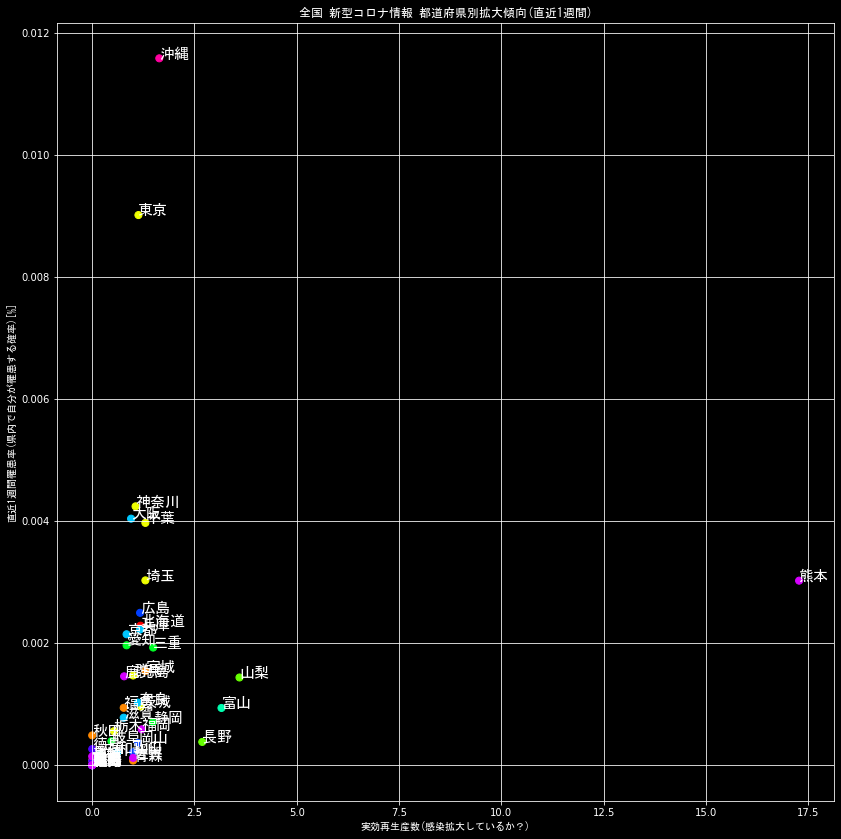

In [53]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]
for k, v in populations.items():
    cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
    texts[v['code'] - 1] = v['ja']
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
plt.title(tw_body_1w, fontname=FONT_NAME)
show_and_clear(fig, "images/ern-1w_poss.jpg")

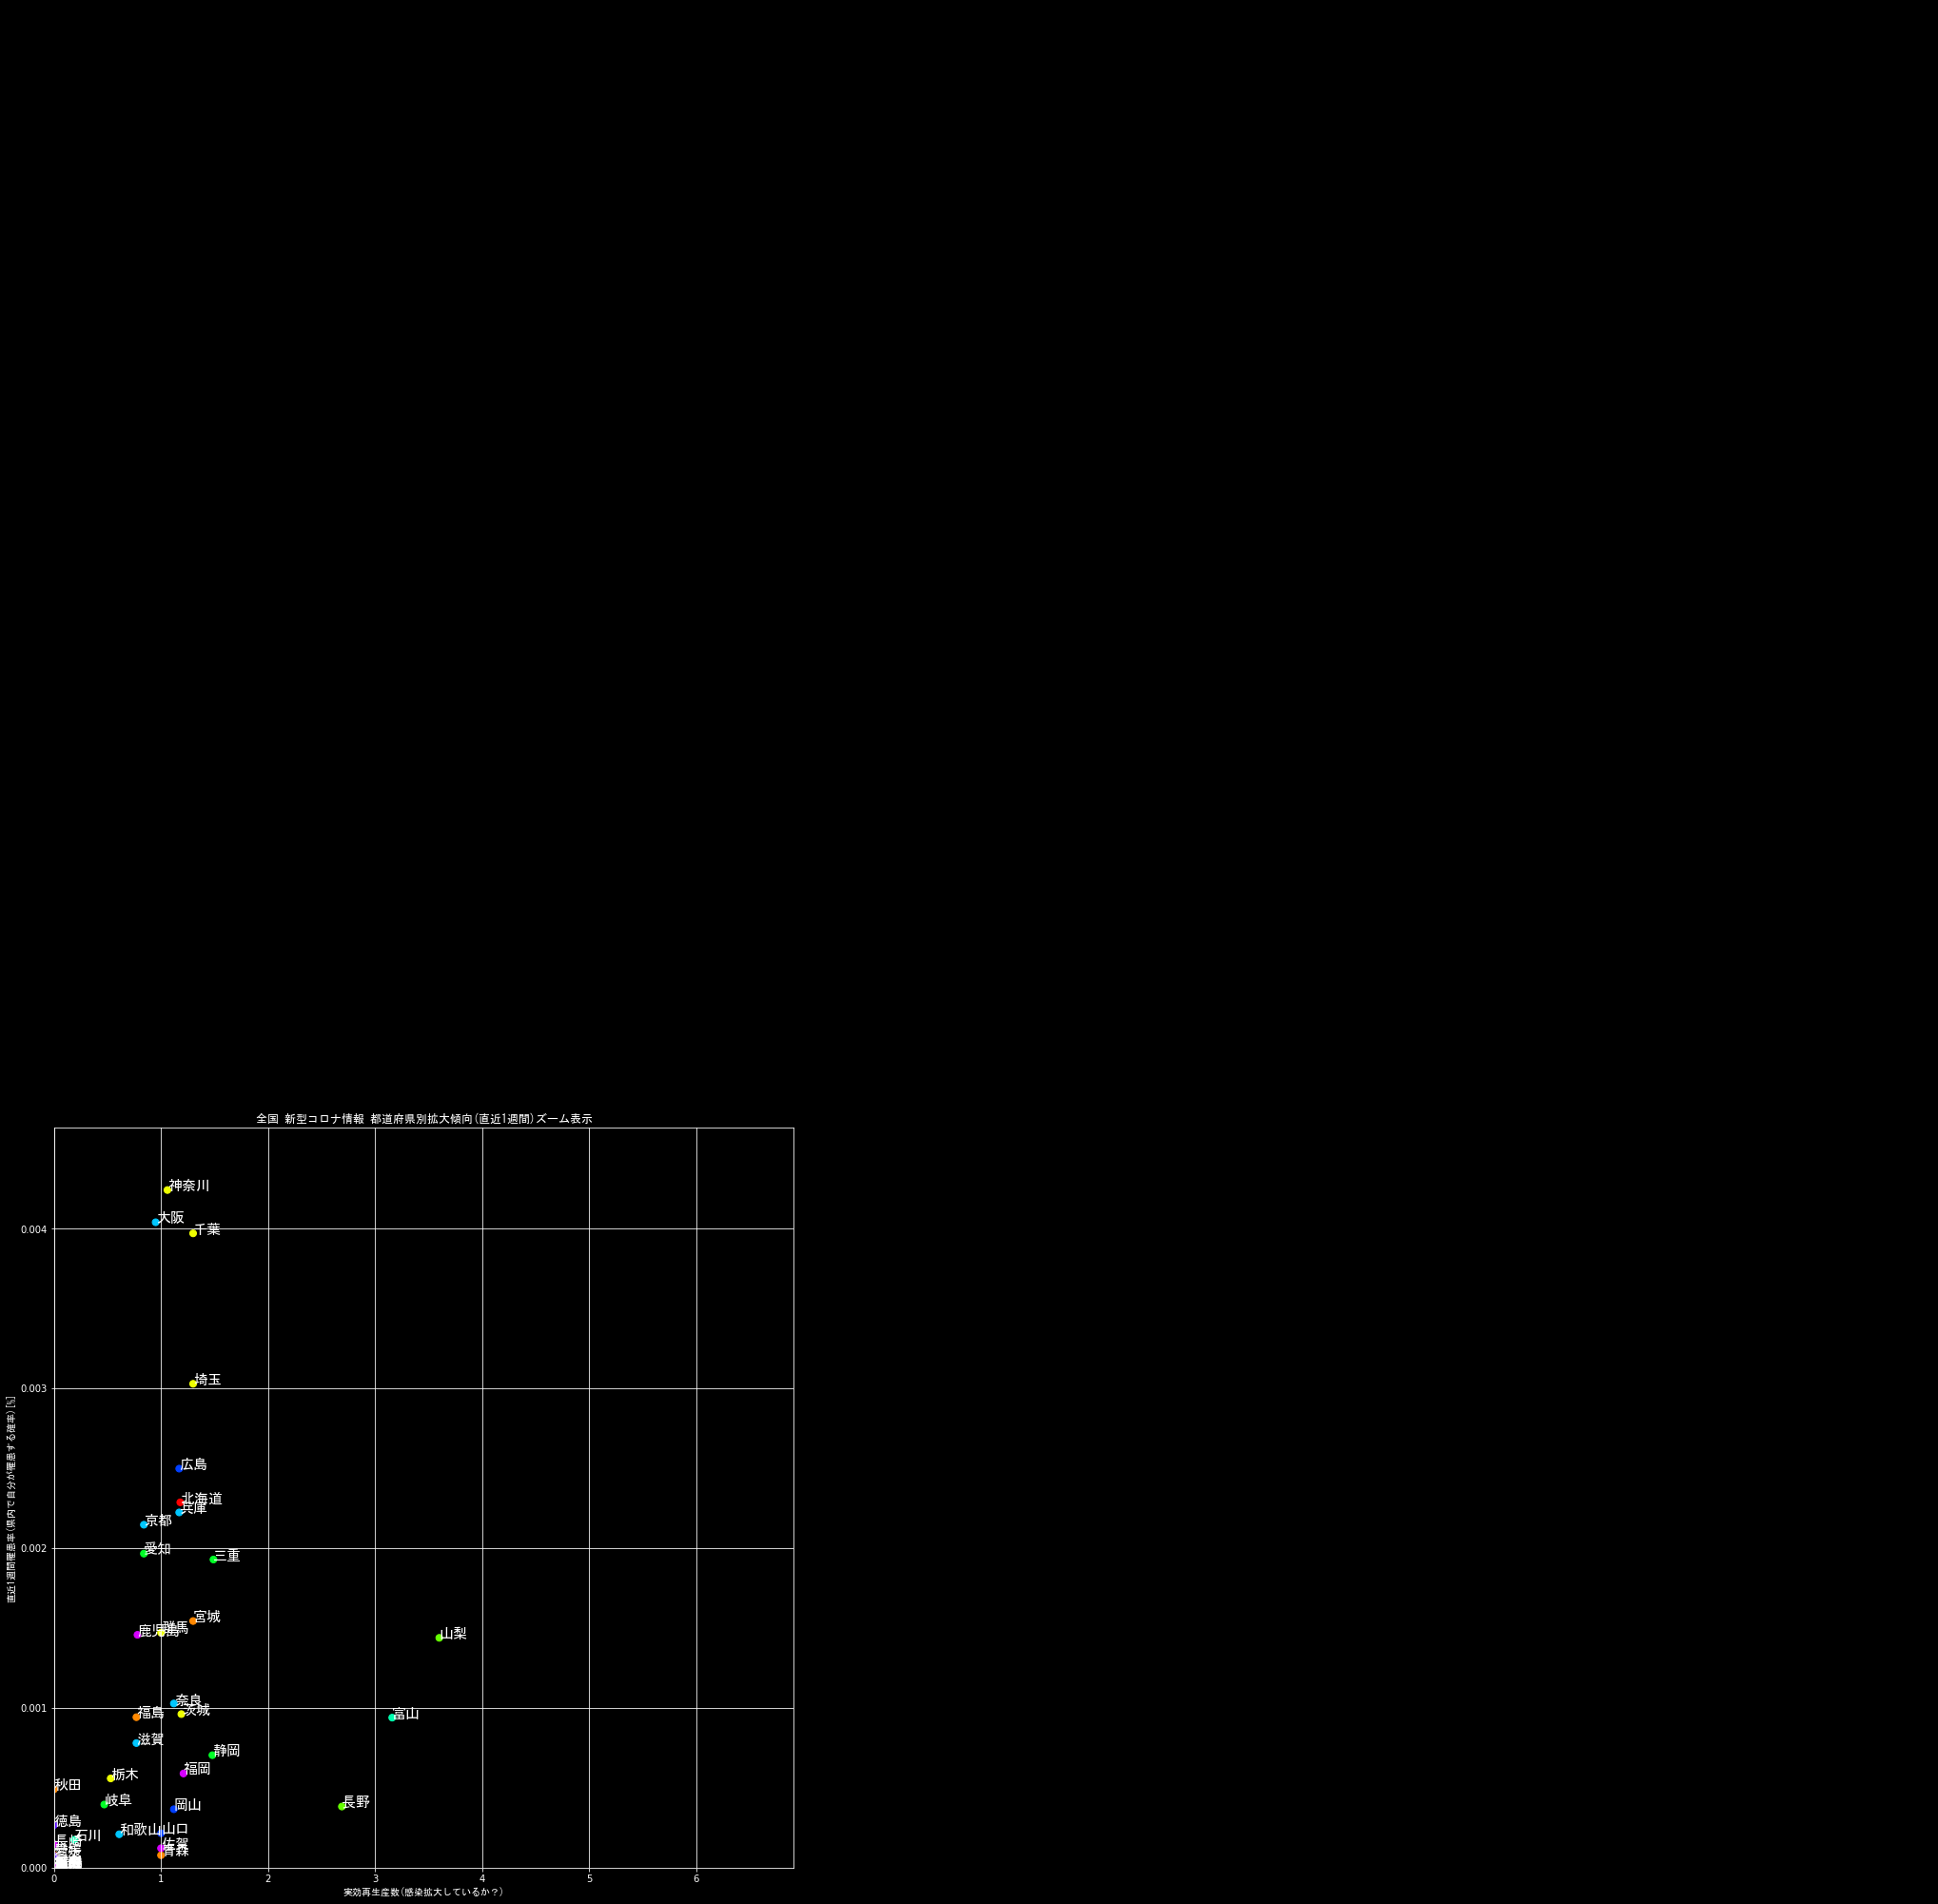

In [54]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
plt.xlim(0, np.max(latest_erns[1:]) * 0.4)
plt.ylim(0, np.max(incid1w_rate[1:]) * 0.4)
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
plt.title(tw_body_1w_zoom, fontname=FONT_NAME)
show_and_clear(fig, "images/ern-1w_poss-zoom.jpg")

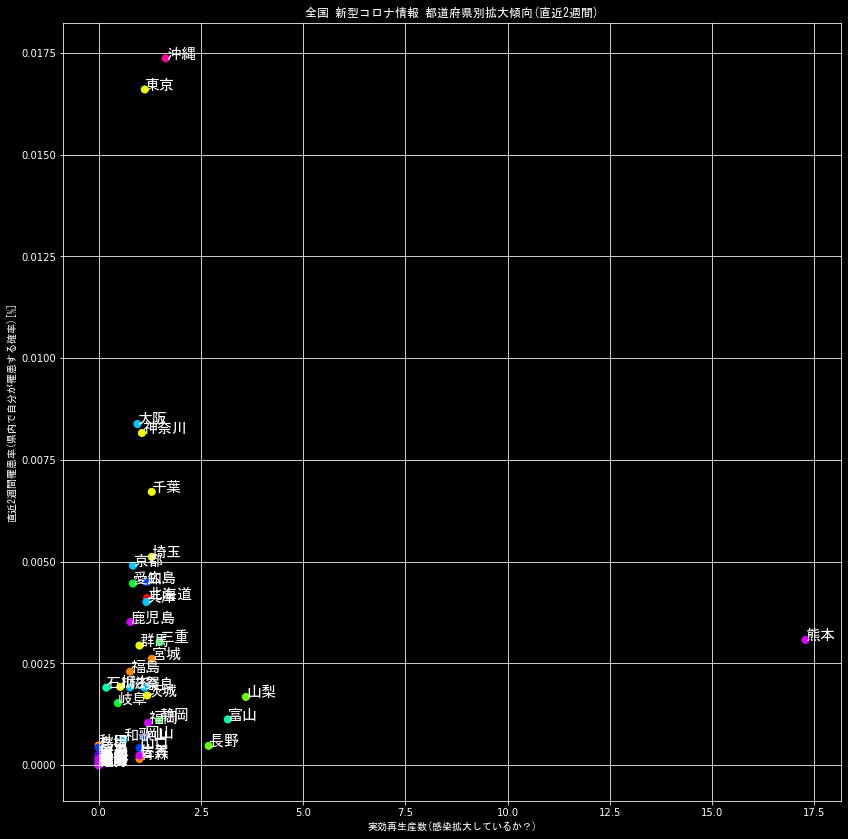

In [55]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
plt.title(tw_body_2w, fontname=FONT_NAME)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
show_and_clear(fig, "images/ern-2w_poss.jpg")

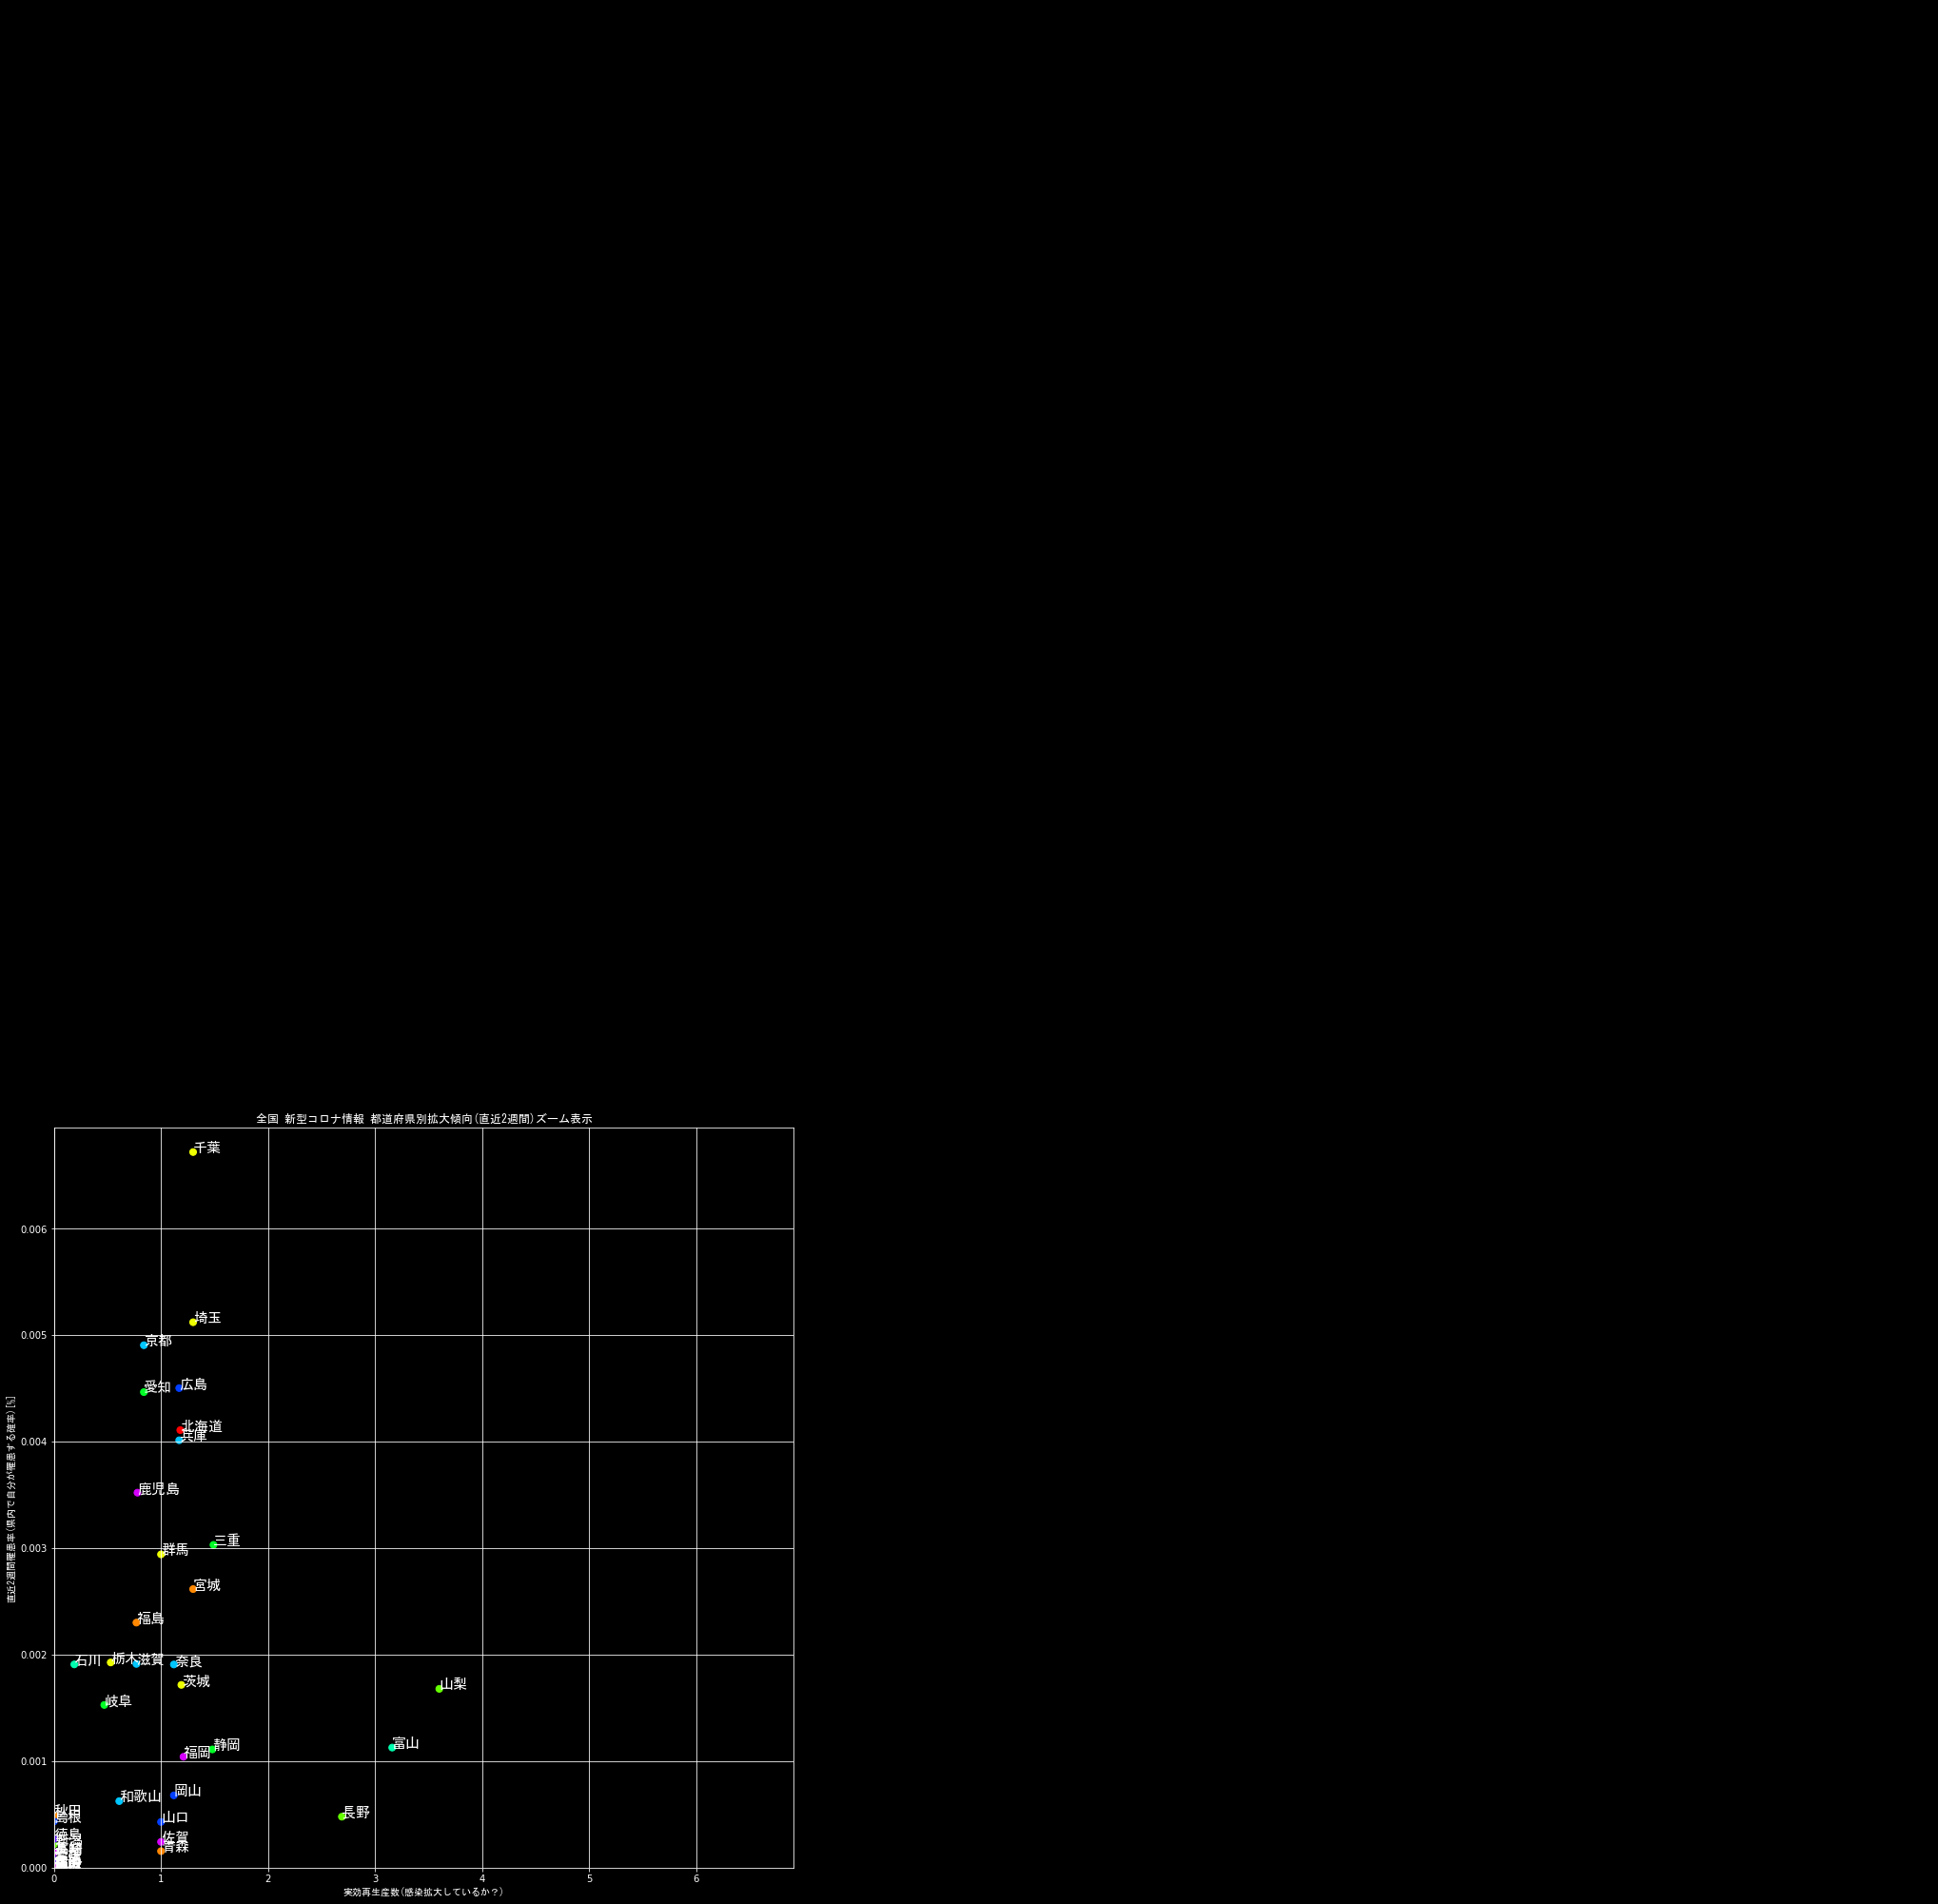

In [56]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.xlim(0, np.max(latest_erns[1:]) * 0.4)
plt.ylim(0, np.max(incid2w_rate[1:]) * 0.4)
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
plt.title(tw_body_2w_zoom, fontname=FONT_NAME)
show_and_clear(fig, "images/ern-2w_poss-zoom.jpg")

In [57]:
def mak_japan_heatmap(filename, title, npa1d):
    plt.close()
    plt.style.use("dark_background")
    plt.subplots_adjust(left=0.07, right=0.99, bottom=0.07, top=0.95)
    plt.title(title, fontname=FONT_NAME)
    plt.rcParams['figure.figsize'] = 6, 6
    cmap = plt.get_cmap("Reds")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    plt.colorbar(cm.ScalarMappable(norm, cmap))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    pict = picture(map_cols)
    plt.imshow(pict)
    plt.savefig(filename)

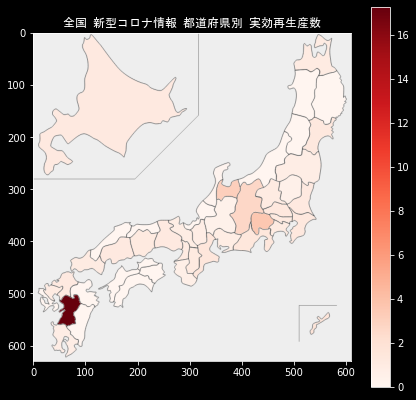

In [58]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
mak_japan_heatmap('images/japan-erns.jpg', tw_body_map_erns, latest_erns)

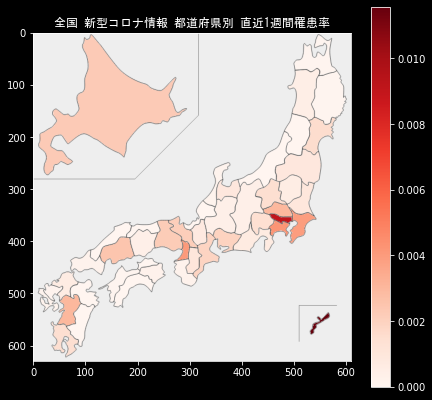

In [165]:
tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
mak_japan_heatmap('images/japan-1w.jpg', tw_body_map_1w, incid1w_rate)

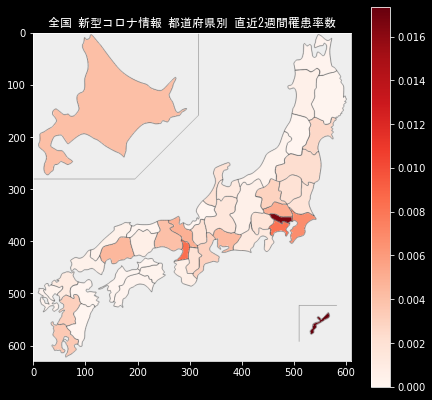

In [60]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率"
mak_japan_heatmap('images/japan-2w.jpg', tw_body_map_2w, incid2w_rate)

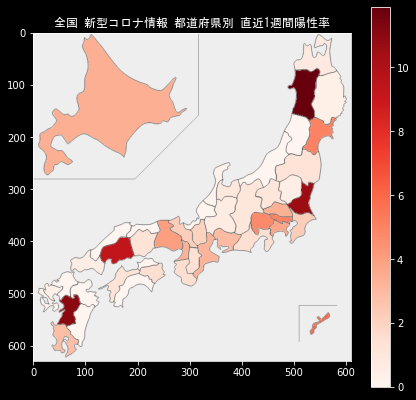

In [163]:
tw_body_map_rate1w = "全国 新型コロナ情報 都道府県別 直近1週間陽性率"
mak_japan_heatmap('images/japan-rate1w.jpg', tw_body_map_rate1w, test1w_rate)

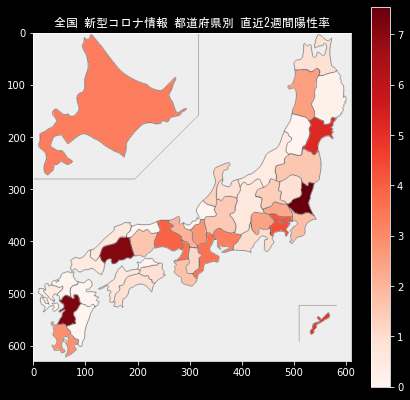

In [164]:
tw_body_map_rate2w = "全国 新型コロナ情報 都道府県別 直近2週間陽性率"
mak_japan_heatmap('images/japan-rate2w.jpg', tw_body_map_rate2w, test2w_rate)

In [38]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " (東洋経済 " + today_str + " 現在)"
#tweet_with_image(tw, "images/ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
#tweet_with_image(tw, "images/ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "images/ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "images/ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [39]:
tweet_with_image(tw, 'images/japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
#tweet_with_image(tw, 'images/japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'images/japan-2w.jpg', tw_body_map_2w + tw_body_postfix)